In [1]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt

# Import the Feedforward-NN
It has to bee a SequentialNN

In [2]:
"""
nn = SequentialNN([28 * 28 * 1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device('cpu')), strict=False)
"""

"""
nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc_6x256.pth", map_location=torch.device('cpu')), strict=False)
"""


nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc 4x256.pth", map_location=torch.device("cpu")), strict=False)



<All keys matched successfully>

In [3]:
parameter_list = list(nn.parameters())
output_size = 10
number_layer = (len(parameter_list) - 2) // 2

# Load the data to apply the verification process for

In [4]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.to("cpu").numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [5]:
transform = Compose([ToTensor(),  Normalize(0.5, 0.5)])
training_data = MNIST(root="../../mnist", train=True, download=True, transform=transform)

# Settings for the optimization 

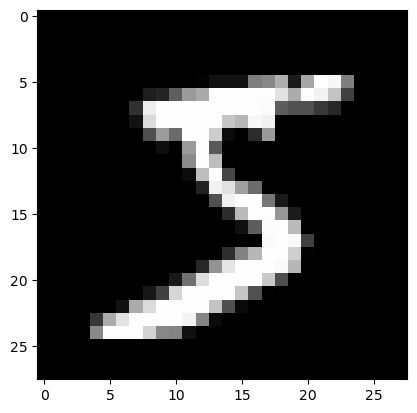

The label is 5
NN classifies image correctly as 5


In [6]:
# image to do the verification for
image_index = 0

# epsilon radius
eps = 0.026

# whether a verification attempt should be done using just MILP encoding for comparison (can take long)
use_milp = True

image, label = training_data[image_index]
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(f"The label is {label}")

if torch.argmax(nn(torch_image)).item() == label:
    print("NN classifies image correctly as {}".format(label))
else:
    print("NN classifies image wrong")


# Add the objective to the optimization problem
in this case we want to find the maximum difference between any one neuron and the target neuron (label)

In [7]:
def add_output_constraints(model, nn_layer_out_bounds, label, output_vars, sovler_bound=1e-3):
    """
    
    :param model: the optimization problem in gurobi encoding the NN
    :param nn_layer_out_bounds: torch.Tensor, approximating the upper and lower bounding the output layer of the NN
    :param label: index of the label or target neuron which is compared against
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :param sovler_bound: provides a bound for the gurobi solver. If this bound is achieved, the optimizer stops
    """
    
    out_lb = nn_layer_out_bounds[-1][0].detach().cpu().numpy()
    out_ub = nn_layer_out_bounds[-1][1].detach().cpu().numpy()
    
    difference_lb = out_lb - out_ub[label]
    difference_ub = out_ub - out_lb[label]
    difference_lb = difference_lb.tolist()
    difference_ub = difference_ub.tolist()
    
    difference_lb.pop(label)
    difference_ub.pop(label)
    
    min_diff = min(difference_lb)
    max_diff = max(difference_ub)
    
    difference = model.addVars(9, lb=difference_lb, ub=difference_ub, name="diff_var")
    model.addConstrs((difference[i] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(0, label)), name="diff_const0")
    model.addConstrs((difference[i - 1] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(label + 1, 10)), name="diff_const1")

    max_var = model.addVar(lb=min_diff, ub=max_diff, name="max_var")
    model.addConstr(max_var == grp.max_(difference))

    if sovler_bound != None:
        model.setParam("BestObjStop", sovler_bound)

    model.update()
    model.setObjective(max_var, grp.GRB.MAXIMIZE)

# Get the output variables by name 
given the gurobi model, the output size of the NN and the index of output layer

In [8]:
def get_output_vars_snv_milp(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("affine_var{}[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [9]:
def get_output_vars_dhov(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("output_layer_[{}]_[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

# Defining function to call Gurobi optimizer

In [10]:
def optimize_model(model, output_vars):
    """
    
    :param model: the optimization problem in gurobi encoding the NN and the objective 
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :return True if verification was successful, else false 
    """
    
    start = time.time()
    model.update()
    model.optimize()
    
    if model.Status == grp.GRB.OPTIMAL or model.Status == grp.GRB.USER_OBJ_LIMIT:
        
        for i, var in enumerate(output_vars.tolist()):
            print("var {}: {}".format(i, var.getAttr("x")))
        max_var = model.getVarByName("max_var").getAttr("x")
        
        if max_var < 0:
            print("property verified with max difference {}".format(max_var))
            return True
        else:
             print("property NOT verified with max difference {}".format(max_var))
             return False

    elif model.Status == grp.GRB.INFEASIBLE:
        print("model infeasible")

        model.computeIIS()
        print("constraint")
        all_constr = model.getConstrs()

        for const in all_constr:
            if const.IISConstr:
                print("{}".format(const))

        print("lower bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISLB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

        print("upper bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISUB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

    print("time to optimize: {}".format(time.time() - start))
    return False

# Calculate box-bounds to provide a rough approximation of NN

In [11]:
input_flattened = torch.flatten(torch_image)
simple_bounds_affine_out, simple_bounds_layer_out = nn.calculate_box_bounds([input_flattened.add(-eps), input_flattened.add(eps)])
print(simple_bounds_affine_out[-1][0].tolist())
print(simple_bounds_affine_out[-1][1].tolist())


[-447.58158788695613, -457.60137986702193, -420.394467466995, -457.2406530142613, -442.7217959428594, -433.36375654809694, -483.0557937961213, -457.09372539883367, -446.4548542945928, -446.44332967384594]
[418.1154439024803, 432.44988057987507, 441.3332469165784, 445.78964202743487, 464.9142726360751, 502.7446128012739, 428.9454169068706, 511.97091645041814, 460.7664058773673, 458.0562638044689]


# Do Single-Neuron-Verification

In [12]:
t = time.time()

# define the Verifier
snv_verifier = SingleNeuronVerifier(nn, torch_image, eps, print_log=False, print_new_bounds=True, optimize_bounds=True)

# generate the constraints
snv_verifier.generate_constraints_for_net()
snv_model = snv_verifier.model
snv_model.update()

# add the objective to the gurobi model
snv_out_vars = get_output_vars_snv_milp(snv_model, output_size, number_layer * 2)
add_output_constraints(snv_model, simple_bounds_layer_out, label, snv_out_vars, sovler_bound=None)
print("constraint generation time: {}".format(time.time() - t))

print("start with optimization")
optimize_model(snv_model, snv_out_vars)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-14
================ layer 0 ===============
================ layer 1 ===============
        0, lower: new 1.1201646595645012, old -0.6894489461394144
        0, upper: new 1.8819674443712948, old 3.713398869947881
        1, lower: new 0.8348111766834623, old -0.871799006453712
        1, upper: new 1.527300553110348, old 3.208888302357581
        2, lower: new 0.31526804677926995, old -1.3548875231748712
        2, upper: new 0.9616555830929736, old 2.6502527928927355
        3, lower: new -0.9836839082360562, old -2.4307315925294013
        3, upper: new -0.3645778757735054, old 1.0988104918983792
        4, lower: new -0.5945772556526745, old -1.999132905022828
        4, upper: new -0.029773221722964198, old 1.423526311859865
        5, lower: new 0.45121421418250574, old -1.1404900335119226
        5, upper: new 1.2071538716158647, old 2.856153135603157
        6, lower: new -0.815971348308458

False

# Do MILP-Verification if wanted

In [13]:
if use_milp:
    # define the Verifier
    milp_verifier = MILPVerifier(nn, torch_image, eps, print_log=False)
    
    # generate the constraints
    milp_verifier.generate_constraints_for_net()
    milp_model = milp_verifier.model
    milp_model.update()
    
    # add the objective to the gurobi model
    milp_out_vars = get_output_vars_snv_milp(milp_model, output_size, number_layer * 2)
    add_output_constraints(milp_model, simple_bounds_layer_out, label, milp_out_vars)
    
    print("start with optimization")
    optimize_model(milp_model, milp_out_vars)

start with optimization
time to optimize: 3.067269802093506


In [14]:
print(snv_verifier.bounds_affine_out)
print(snv_verifier.bounds_layer_out)

[[tensor([ 0.2509, -1.6225, -2.0252,  0.0307, -0.0804, -1.1500,  0.5777, -1.8816,
         0.1334,  1.1522, -1.7677, -1.2663,  0.3411, -0.3749,  1.5405,  0.3186,
        -1.6473, -0.4920, -0.6783, -0.4322, -0.3047, -0.1271,  0.3531, -0.8784,
        -0.8522,  1.1951,  1.0654,  0.1179,  0.3496,  0.5079,  0.9164, -1.2597,
         0.1835,  0.1987, -1.1910, -0.0752, -1.3080, -0.7868, -0.1298,  0.4290,
        -1.3379,  0.0825,  0.1832,  0.6228, -1.2850, -0.8769,  0.6351, -0.7930,
         1.6981,  0.0522, -0.9513,  0.8760, -0.2547, -0.8723, -0.7872,  0.5334,
         0.2388,  0.1391,  1.5467,  0.7596,  0.6849,  1.2183,  0.4913,  0.3727,
        -1.4201, -1.5021,  0.4134, -0.9185,  0.5005, -0.1202,  0.6142,  0.7632,
        -0.6860, -0.7598, -0.1486, -1.2038, -1.9459, -0.3299, -0.1798,  0.1353,
         0.2146, -0.9594, -0.8864, -0.1237, -1.2053,  1.1298,  0.1858, -1.3538,
        -0.0206,  0.1964,  0.0168,  0.1356,  1.2375,  0.3129,  1.6475,  0.4788,
        -2.2745, -0.5119,  1.5372,  0.

# Attempt verification using DHOV
See MultiDHOV.py and ICNNFactory.py for detailed documentation about the parameters

In [15]:
from script.DHOV.Sampling.PerGroupLineSearchSampling import PerGroupLineSearchSamplingStrategy
center = torch.flatten(torch_image)
sampling_strategy = PerGroupLineSearchSamplingStrategy(center, eps, nn, keep_ambient_space=True, sample_new=False, sample_count=1000)
# number of neurons which are in one group
group_size = 20

# number of data points which are generated to train the ICNN on
sample_count = 50

# method of sampling data points
#sampling_method = "per_group_sampling"

# Size of each layer of the ICNN except for the input layer. (given by group size)
net_size = [5, 1]

# picking the typ of ICNN to use
#icnn_factory = ICNNFactory("approx_max", net_size, maximum_function="SMU", function_parameter=0.3)
icnn_factory = ICNNFactory("logical", net_size, always_use_logical_layer=False)
#icnn_factory = ICNNFactory("standard", net_size, adapt_layer_for_init=True)

bounds_affine_out_snr, bounds_layer_out_snr = snv_verifier.bounds_affine_out, snv_verifier.bounds_layer_out

overall_time = time.time()
dhov_verifier = multidhov.MultiDHOV()
dhov_verifier.start_verification(nn, torch_image, icnn_factory, group_size, eps=eps, icnn_epochs=200,
                                init_affine_bounds=bounds_affine_out_snr, init_layer_bounds=bounds_layer_out_snr,
                                 icnn_batch_size=10000, use_over_approximation=True, break_after=None,
                                 tighten_bounds=True,
                                 use_fixed_neurons_in_grouping=False, layers_as_snr=[], layers_as_milp=[3],
                                 force_inclusion_steps=3, preemptive_stop=True,
                                data_grad_descent_steps=0, opt_steps_gd=100,
                                 train_outer=False, print_training_loss=False, print_new_bounds=False,
                                 grouping_method="consecutive", group_num_multiplier=5, store_samples=False, print_optimization_steps=False, print_last_loss=False,
                                 should_plot="none", optimizer="SdLBFGS", init_network=True, adapt_lambda="included", sampling_strategy=sampling_strategy)
print("overall time: {}".format(time.time() - overall_time))

/home/ufuk/Documents/Programming/ICNN_verification/script/DHOV/Sampling/PerGroupLineSearchSampling.py:19: UserWarning: keep_ambient_space is True and sampling method is per_group_sampling. Keeping previous samples is not supported when using per group sampling
  warnings.warn("keep_ambient_space is True and sampling method is per_group_sampling. "
/home/ufuk/Documents/Programming/ICNN_verification/script/DHOV/MultiDHOV.py:188: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "



approximation of layer: 0
    number of fixed neurons for current layer: 182
    layer progress, group 1 of 4 


/home/ufuk/Documents/Programming/ICNN_verification/script/Optimizer/sdlbfgs.py:83: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847130/work/torch/csrc/utils/python_arg_parser.cpp:1630.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))
/home/ufuk/Documents/Programming/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = b - torch.tensor(value, device=device)


        time for training: 2.095198154449463

Interrupt request received
        actual verification time 0.353546142578125
        time for verification: 0.3890721797943115
    layer progress, group 2 of 4 
        time for training: 1.2675261497497559
        actual verification time 1.8296260833740234
        time for verification: 1.8639583587646484
    layer progress, group 3 of 4 
        time for training: 1.5185825824737549
        actual verification time 0.5642950534820557
        time for verification: 0.5986664295196533
    layer progress, group 4 of 4 
        time for training: 2.359684705734253
        actual verification time 0.23228907585144043
        time for verification: 0.25928521156311035

approximation of layer: 1
    time for icnn_bound calculation: 8.30313754081726
    number of fixed neurons for current layer: 192
    layer progress, group 1 of 4 
        time for training: 2.5840964317321777
        actual verification time 1.3521249294281006
        time fo

# Getting an overview over what DHOV has done
show the neuron groups created by DHOV for each layer by index

In [16]:
for i, groups_in_layer in enumerate(dhov_verifier.all_group_indices):
    print(f"Layer {i}")
    for k, group in enumerate(groups_in_layer):
        print(f"    Group {k}: {group}")

Layer 0
    Group 0: [4, 13, 17, 18, 19, 20, 21, 35, 38, 52, 69, 72, 73, 74, 77, 78, 83, 88, 97, 100]
    Group 1: [103, 105, 106, 108, 120, 121, 125, 129, 131, 132, 133, 137, 143, 144, 145, 148, 149, 150, 152, 153]
    Group 2: [158, 159, 161, 164, 168, 169, 172, 176, 179, 181, 183, 186, 190, 192, 193, 194, 206, 210, 213, 214]
    Group 3: [216, 226, 228, 232, 233, 235, 237, 241, 242, 243, 247, 248, 250, 251]
Layer 1
    Group 0: [10, 22, 25, 37, 38, 39, 41, 51, 53, 60, 66, 67, 68, 72, 74, 75, 76, 82, 83, 84]
    Group 1: [85, 87, 89, 97, 103, 106, 110, 118, 119, 121, 122, 129, 132, 133, 136, 139, 140, 145, 148, 159]
    Group 2: [161, 162, 163, 166, 171, 175, 181, 182, 184, 190, 195, 197, 199, 207, 211, 212, 215, 218, 226, 228]
    Group 3: [235, 244, 246, 252]
Layer 2
    Group 0: [7, 16, 18, 21, 39, 40, 43, 58, 66, 67, 68, 72, 80, 84, 85, 93, 95, 97, 100, 101]
    Group 1: [105, 106, 107, 113, 124, 130, 133, 134, 138, 140, 141, 145, 147, 149, 157, 159, 162, 168, 180, 182]
    Group

show the output bounds for the NN. Hopefully these are better than the box-bounds and the bounds obtained by the Single-Neuron-Verification

In [17]:
print(dhov_verifier.bounds_affine_out[-1][0].tolist())
print(dhov_verifier.bounds_affine_out[-1][1].tolist())

[-447.58158788695613, -457.60137986702193, -420.394467466995, -457.2406530142613, -442.7217959428594, -433.36375654809694, -483.0557937961213, -457.09372539883367, -446.4548542945928, -446.44332967384594]
[418.1154439024803, 432.44988057987507, 441.3332469165784, 445.78964202743487, 464.9142726360751, 502.7446128012739, 428.9454169068706, 511.97091645041814, 460.7664058773673, 458.0562638044689]


# Starting the optimization process

In [18]:
# make changes on a copy of the gurobi model generated by DHOV
dhov_model = dhov_verifier.nn_encoding_model.copy()
dhov_model.update()
dhov_out_vars = get_output_vars_dhov(dhov_model, output_size, number_layer)

In [19]:
add_output_constraints(dhov_model, simple_bounds_layer_out, label, dhov_out_vars, sovler_bound=10)

In [20]:
optimize_model(dhov_model, dhov_out_vars)

var 0: -2.4418354042287262
var 1: 2.735114897592288
var 2: 1.7364906875736725
var 3: 11.189711113287473
var 4: -10.685702165693998
var 5: 9.216956355830261
var 6: -7.822179178110497
var 7: 0.4379984880686827
var 8: -1.5713125462390387
var 9: 0.02474429243723897
property NOT verified with max difference 1.9727547574572126


False